In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import time
from matplotlib import animation, rc
from IPython.display import HTML
# plt.style.use('default')

# PHYS 512 final project: N-body simulation

Tristan Ménard

260675783

## Part 1:  A single particle at rest remains at rest

In [2]:
###############################################################
# SIMULATION SETTINGS
xmin = -2; xmax = 2; ymin = -2; ymax = 2 # the edges of the simulation box
npix = 256 # the resolution of the simulation (works best for an odd number of pixels per side)
n = 1 # the number of particles

dt = 0.1 # the time step
nstep = 100 # the number of timesteps to simulate
###############################################################
extent = [xmin, xmax, ymin, ymax] # dimensions of the simulation box

# Place a particle inside the simulation box (choose (x,y)=(1,-1)).
x_particle = np.ones(n)
y_particle = -np.ones(n)

# Start the particle at rest.
vx = np.zeros(n)
vy = np.zeros(n)

The position and velocity of the particle are set up. Now, we need to write a function that gives the 2-dimensional density on a grid of the desired resolution.

In [3]:
def  get_density(x_particles, y_particles, nbins, extent):
    # Define the bin edges.
    xmin, xmax, ymin, ymax = extent
    xedges = np.linspace(xmin, xmax, nbins+1)
    yedges = np.linspace(ymin, ymax, nbins+1)
    # Get the indices of the bin array corresponding to the location of the particles.
    x_idx = np.digitize(x_particles, xedges)-1
    y_idx = np.digitize(y_particles, yedges)-1
    
    # Initialize an array for the number of particles in each bin.
    particles_per_bin = np.zeros([nbins, nbins])
    # Add up the number of particles in each bin.
    for i in range(len(x_idx)):
        particles_per_bin[y_idx[i],x_idx[i]] += 1
    # Return the number of particles per bin divided by the area of each bin as the density.
    # --> implies that the mass of each particle is uniformly set to 1.
    grid_cell_size = xedges[1]-xedges[0]
    return particles_per_bin/grid_cell_size, xedges, yedges, np.column_stack((x_idx, y_idx))

In [4]:
# Get the 2-dimensional npix resolution density array:
density, xedges, yedges, bin_idx = get_density(x_particle, y_particle, npix, extent)

# The gridpoints are the center points of each bin (grid cell).
x_gridpt = (xedges[1:]+xedges[:-1])/2
y_gridpt = (yedges[1:]+yedges[:-1])/2

The gravitational potential array for the particle can be obtained by convolving the density array with $\dfrac{1}{|\mathbf{r}|}$. This convolution can be done very rapidly in only $N\log(N)$ operations using FFTs. 

Explicitly, the we are solving for the gravitational potential $\Phi$ in the Poisson equation for gravity. 

$$
\nabla^2\Phi(\mathbf{r}) = 4\pi G \rho(\mathbf{r}) \\
$$

The solution to the Poisson equation can be found using a Green's function. Then, rather than calculating the computationally expensive Green's solution integral, we treat the solution as the convolution of the density $\rho$ and $\dfrac{1}{|\mathbf{r}|}$. The convolution in real space is simply the mutlplication of $\hat{\rho}$ and $\dfrac{1}{|\mathbf{\hat{r}}|}$ in Fourier space, where $\hat{\rho}$ and $\dfrac{1}{|\mathbf{\hat{r}}|}$ are the Fourier transforms of their respective real space counterparts.

$$
\Phi(\mathbf{r}) = - G \int \frac{\rho(\mathbf{r'})}{|\mathbf{r}-\mathbf{r'}|} \text{d}^3\mathbf{r'} = - G\ \mathcal{F}^{-1} \bigg\{ \hat{\rho} \cdot \frac{1}{|\mathbf{\hat{r}}|} \bigg\}
$$

Once the scalar potential field has been obtained, the vectorial force components acting on grid due to the gravitational potentials of other particles is easily calculated via the gradient of the potential field.

$$
\mathbf{F} = -\mathbf{\nabla} \Phi
$$

In [5]:
def get_Green(x, y, soft=0.01):
    '''
    Returns the 2-dimensional array representing the Green's function given by the inverse of the distance of each bin from some central point.
    Takes an array for the x positions of the gridpoints (x) and the y positions of the gridpoints (y).
    Can also take some softening constant (soft=0.01 by default).
    '''
    X, Y = np.meshgrid(x, y)
    # When the number of grid cells is odd, simply calculate the distance to each cell from the central gridpoint as R = sqrt(X^2 + Y^2).
    # When the number of grid cells is even, there is no central gridpoint from which to calculate the distances.
    # Instead, calculate the distances from a shifted point at (x,y) = (h/2, h/2), where h is the side length of a grid cell.
    # The distances between gridpoints are still the same, but the pattern better represents a global 
    shift = 0
    if len(x)%2 == 0: # only applies when there are even number of grid cells per side
        h = x[1]-x[0]
        shift = h/2   
    R = np.sqrt((X-shift)**2 + (Y-shift)**2)
    # Use softening to avoid an infinite potential at r=0
    R[R < soft] = soft
    return 1/R

def get_periodic_potential(density, green):
    '''
    Returns a 2-dimensional array for the potential with periodic boundary conditions.
    The potential is evaluated using the convolution of the density and the Green's function.
    In Fourier space, the convolution is simply the multiplication of the density and thhe Green's function.
    Shifts the potential to be centered at the correct bin, accounting for differences when the number of bins is even or odd.
    '''
    density_ft = np.fft.fft2(density)
    green_ft = np.fft.fft2(green)
    potential = np.real(np.fft.ifft2(density_ft*green_ft))
    potential = np.fft.fftshift(potential)
    if len(density) % 2 == 1:
        potential = np.roll(np.roll(potential, 1, axis=0), 1, axis=1)
    return potential

In [6]:
# Convolve the density array with the Green's function array to get the potential.
green = get_Green(x_gridpt, y_gridpt, soft=0.01)
pot = get_periodic_potential(density, green)

# Get the force acting on each grid cell from the gradient of the potential:
grad_pot = np.gradient(pot)
Fx = grad_pot[1]
Fy = grad_pot[0]

We now have the sum of the forces actings on each bin (grid cell) in the simulation box. These forces will be used to update the position of the particles going into the next time step. But first, let's just check that everything is working as expected...

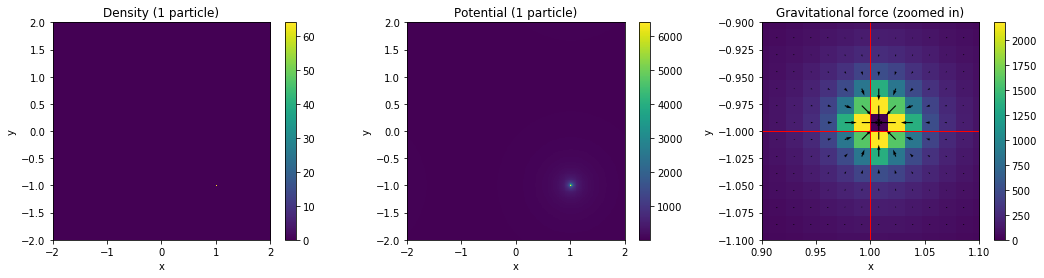

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

ax1.set_title('Density (1 particle)')
im1 = ax1.imshow(density, origin='lower', extent=extent)
ax1.set(xlabel='x', ylabel='y')
f.colorbar(im1, ax=ax1)

ax2.set_title('Potential (1 particle)')
im2 = ax2.imshow(pot, origin='lower', extent=extent)
ax2.set(xlabel='x', ylabel='y')
# ax2.set(xlabel='x', ylabel='y', xlim=(x_particle-0.1,x_particle+0.1), ylim=(y_particle-0.1,y_particle+0.1))
f.colorbar(im2, ax=ax2)

ax3.set_title('Gravitational force (zoomed in)')
im3 = ax3.imshow(np.sqrt(Fx**2+Fy**2), origin='lower', extent=extent)
ax3.quiver(x_gridpt, y_gridpt, Fx, Fy, scale=25000, width=0.005) # show the force vectors with arrows; adjust the arrows' size for visibility
ax3.axhline(y_particle, c='r', lw=1)
ax3.axvline(x_particle, c='r', lw=1)
ax3.set(xlabel='x', ylabel='y', xlim=(x_particle-0.1,x_particle+0.1), ylim=(y_particle-0.1,y_particle+0.1))
f.colorbar(im3, ax=ax3)

plt.show()

The particle at (1,-1) is sitting in its expected bin location (note: the bottom and left sides of each cell are considered to be inside the bin; the right and top sides are considered to be outside the bin). The potential increases as we approach the particle's location. I account for this "error" by taking the positive gradient of the potential to get the force later, instead of the negative gradient, which gives the correct end result. So, the gravitational potential due to the particle is sensible, and the forces are all attractive forces towards the particle's current bin. With this sanity check out of the way, the next step is to update the particle's position and velocity using the current position $\mathbf{r}_i$, velocity $\mathbf{v}_i$, and the acceleration $\mathbf{a}_i$. Notably, the acceleration is equivalent to the force $\mathbf{F}_i \equiv m_i\mathbf{a}_i$ because the masses are all equal to 1.

$$
\mathbf{r}_{i+1} = \mathbf{r}_i + \mathbf{v}_i dt \\
\mathbf{v}_{i+1} = \mathbf{v}_i + \mathbf{F}_i dt
$$

In [8]:
def update_particles(x, y, vx, vy, Fx, Fy, dt):
    x += vx*dt
    y += vy*dt
    vx += Fx*dt
    vy += Fy*dt
    return x, y, vx, vy

This algorithm can be improved to second order for relatively little extra work by using the leapfrog method. Leapfrogging updates the particle positions at every integer time step, using the velocities from the previous half step. The first half-step velocities must be calculated manually as:

$$
\mathbf{v}_{1/2} = \mathbf{v}_0 + \mathbf{F}_0 \frac{dt}{2}
$$

Then, the leapfrog procedure continues as follows:

$$
\begin{aligned}
\mathbf{r}_{i} &= \mathbf{r}_{i-1} + \mathbf{v}_{i-1/2} dt \\
\mathbf{v}_{i+1/2} &= \mathbf{v}_{i-1/2} + \mathbf{F}_i dt
\end{aligned}
$$

Again, these equations are valid only when the masses are all equal to 1. Otherwise, the force term should be divided by the mass.

In [9]:
def leapfrog(x, y, vx_half, vy_half, npix, extent, green, bc=None):
    x += vx_half*dt
    y += vy_half*dt
    # Get the forces acting on the particles in their updated positions.
    density, xedges, yedges, bin_idx = get_density(x_particle, y_particle, npix, extent)
    pot = get_periodic_potential(density, green)
    grad_pot = np.gradient(pot)
    Fx = grad_pot[1]
    Fy = grad_pot[0]
    # Calculate the velocities for the next half-step.
    vx_half += Fx[bin_idx[:,1], bin_idx[:,0]]*dt
    vy_half += Fy[bin_idx[:,1], bin_idx[:,0]]*dt
    return x, y, vx_half, vy_half

In [10]:
# Make an array to hold onto the particle's position data at each timestep.
x_all = np.zeros([nstep, n])
y_all = np.zeros([nstep, n])

# Hold onto the particle's initial position.
x_all[0] = x_particle
y_all[0] = y_particle

# Set up the leapfrog algorithm:
# Give the first set of velocities at t = dt/2.
# Note: The required force is the one corresponding to the particle's current bin.
vx_half = vx + Fx[bin_idx[:,1], bin_idx[:,0]]*dt/2
vy_half = vy + Fy[bin_idx[:,1], bin_idx[:,0]]*dt/2
# Update the positions of the particles using the velocities at the half-step.
x_particle += vx_half*dt
y_particle += vy_half*dt
x_all[1] = x_particle
y_all[1] = y_particle

for i in range(2,nstep):
    # Leapfrog to get the particle positions at the following time steps.
    x_particle, y_particle, vx_half, vy_half = leapfrog(x_particle, y_particle, vx_half, vy_half, npix, extent, green)
    x_all[i] = x_particle
    y_all[i] = y_particle

Now, I can show the result of the 1-particle N-body simulation. We should expect that the particle remains at rest as it starts at rest and there are no exterior forces acting on it.

Note that all the animations will be saved externally in mp4 format and may be found in the same folder where this notebook is located.

In [11]:
# Animate it!
t = np.arange(0,nstep*dt,dt)
timestamp = ['t = {:.2f}'.format(ti) for ti in t]

fig = plt.figure()
ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))
scat = ax.scatter([], [])
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes)
plt.close()

def init():
    scat.set_offsets([])
    time_text.set_text('')
    return scat, time_text

def animate(i):
    scat.set_offsets(np.column_stack((x_all[i,:],y_all[i,:])))
    time_text.set_text(timestamp[i])
    return scat,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nstep, interval=100, blit=True)
anim.save('stationary_particle.mp4', dpi=160)

The single particle at rest remained at rest for the entire simulation (nstep = 100, dt = 0.1). Good!

## Part 2: Two particles in a circular orbit

To start this task, I will write a function that does the whole N-body simulation in a single command. We do not expect the orbiting particles to escape the bounds of the simulation box, so no boundary conditions should be necessary just yet.

In [12]:
def nbody(n_particles, x, y, vx, vy, npix, extent, nstep, dt):
    '''
    A function that computes the whole nbody simulation in a single command. The N-body simulation proceeds to the next 
    time step using the leapfrogging method, which is accurate to second order for relatively little extra work. 
    Takes the number of particles (n_particles), the x position array of the particles (x), the y position array (y), 
    the x velocity array (vx), the y velocity array (vy), the number of pixels or grid cell along a side (npix), the bounds 
    of the simulation box (extent), the number of time steps to simulate (nstep), and the size of the time step (dt) as inputs. 
    Returns the x and y positions of the particles at each time step.
    '''
    x_all = np.zeros([nstep, n_particles])
    x_all[0] = x
    y_all = np.zeros([nstep, n_particles])
    y_all[0] = y
    
    # Set up the leapfrog algorithm:
    # Get the forces acting on the particles in their initial positions.
    density, xedges, yedges, bin_idx = get_density(x, y, npix, extent)
    x_gridpt = (xedges[1:]+xedges[:-1])/2
    y_gridpt = (yedges[1:]+yedges[:-1])/2
    green = get_Green(x_gridpt, y_gridpt)
    pot = get_periodic_potential(density, green)
    grad_pot = np.gradient(pot)
    Fx = grad_pot[1]
    Fy = grad_pot[0]
    # Give the first set of velocities at t = dt/2.
    vx_half = vx + Fx[bin_idx[:,1], bin_idx[:,0]]*dt/2
    vy_half = vy + Fy[bin_idx[:,1], bin_idx[:,0]]*dt/2
    # Update the positions of the particles using the velocities at the half-step.
    x += vx_half*dt
    y += vy_half*dt
    x_all[1] = x
    y_all[1] = y
    
    for i in range(2,nstep):
        x, y, vx_half, vy_half = leapfrog(x, y, vx_half, vy_half, npix, extent, green)
        x_all[i] = x
        y_all[i] = y
    return x_all, y_all

For the 2-body circular motion problem, the centripetal force acting on each body must be equal to the gravitational force exerted by the other.

$$
\begin{aligned}
\frac{m_1 v_1^2}{r_1} &= \frac{G m_1 m_2}{(r_1 + r_2)^2}\ \ \ \ \ \ \ \ \text{where we set $G = m_1 = m_2 = 1$ and $r_2 = r_1$} \\
v_1^2 &= \frac{r_1}{(2 r_1)^2} \\
v_1 &= \frac{1}{2\sqrt{r_1}},\ \ \ v_2 = -v_1
\end{aligned}
$$

So, let's set up the N-body simulation with $r_1 = -r_2 = -0.25$, meaning the velocities of the particles should be $v_1 = -v_2 = \frac{1}{2\sqrt{0.25}} = 1$ to achieve circular orbits.

In [13]:
###############################################################
# SETTINGS
xmin = -2; xmax = 2; ymin = -2; ymax = 2 # the edges of the simulation box
npix = 2**9 # the resolution of the simulation (works best 2^N pixels per side)
n = 2 # the number of particles

dt = 0.01 # the time step
nstep = 400 # the number of timesteps to simulate
###############################################################

# Place the particle inside the simulation box.
x_particle = np.array([-0.25,0.25])
y_particle = np.zeros(n)

# Start the particles in circular motion.
vx = np.zeros(n)
vy = np.array([-1,1])

# Give the extent of the simulation box.
extent = [xmin, xmax, ymin, ymax]

x_all, y_all = nbody(n, x_particle, y_particle, vx, vy, npix, extent, nstep, dt)

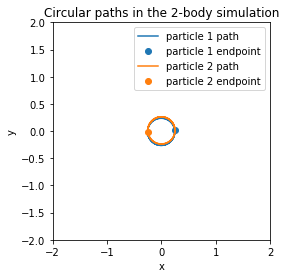

In [14]:
f, ax = plt.subplots()
ax.set_title('Circular paths in the 2-body simulation')
ax.set_aspect('equal')
colours = ['C0', 'C1']
for i in range(n):
    plt.plot(x_all[:,i], y_all[:,i], c=colours[i])
    plt.plot(x_all[-1,i], y_all[-1,i], 'o', c=colours[i])
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['particle 1 path', 'particle 1 endpoint', 'particle 2 path', 'particle 2 endpoint'])
plt.show()

In [15]:
# Animate the particles' motion.
t = np.arange(0,nstep*dt,dt)
timestamp = ['t = {:.2f}'.format(ti) for ti in t]

fig = plt.figure()
ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))
ax.set_aspect('equal')
line1, = ax.plot([], [])
line2, = ax.plot([], [])
scat = ax.scatter(x_all[0,:] , y_all[0,:], c=['C0','C1'])
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes)
plt.close()

def animate(i):
    line1.set_data(x_all[:i+1,0], y_all[:i+1,0])
    line2.set_data(x_all[:i+1,1], y_all[:i+1,1])
    scat.set_offsets(np.column_stack((x_all[i,:],y_all[i,:])))
    time_text.set_text(timestamp[i])
    return scat,

# Save the animation in .mp4 format.
anim = animation.FuncAnimation(fig, animate, frames=nstep, interval=50)
anim.save('circular_motion.mp4', dpi=160)

## Part 3: Large-scale N-body simulation (500,000 particles)

The density function used earlier was very efficient at getting the density bins for a small number of particles. In fact, it was consistently ten times faster than using numpy's histogram2d function. However, histogram2d becomes much more efficient (~5 times faster) than the get_density function I used previously when there are a very large number of particles. So, here I will write a new density function using numpy's histogram2d function. The outputs of this new density function were verified to match the outputs of the previous get_density function.

I am also inserting the mass into the functions for the periodic case because I will need to work with non-uniform masses in a periodic simulation in Part 4.

In [16]:
def get_density_hist2d(x, y, npix, extent, m=None):
    xmin, xmax, ymin, ymax = extent
    if m is None:
        particles_per_bin, xedges, yedges = np.histogram2d(x, y, npix, [[xmin,xmax],[ymin,ymax]])
    else:
        particles_per_bin, xedges, yedges = np.histogram2d(x, y, npix, [[xmin,xmax],[ymin,ymax]], weights=m)
    h = (xmax-xmin)/npix # bin size
    x_bin = ((x-xmin)/h).astype(int) # get the bin location of each particle
    y_bin = ((y-ymin)/h).astype(int)
    return particles_per_bin.T/h, xedges, yedges, np.column_stack((x_bin, y_bin))

### Periodic BCs

First, I will write a function that applies periodic boundary conditions to a set of particles. If a particle is travels to a position that is just outside the bounds of the simulation box, applying this function will relocate this particle inside the box and to the other side (in a periodic manner).

In [17]:
def periodic_particles(x, y, extent):
    xmin, xmax, ymin, ymax = extent
    # Dimensions of the simulation box:
    dx = xmax - xmin
    dy = ymax - ymin
    # If particle is outside the horizontal bounds of the box, move it to the inside of the opposite side.
    x[x < xmin] = x[x < xmin] + dx*(np.abs(x[x < xmin] - xmin)/dx + 1).astype(int)
    x[x >= xmax] = x[x >= xmax] - dx*(np.abs(x[x >= xmax] - xmax)/dx + 1).astype(int)
    # If particle is outside the vertical bounds of the box, move it to the inside of the opposite side.
    y[y < ymin] = y[y < ymin] + dy*(np.abs(y[y < ymin] - ymin)/dy + 1).astype(int)
    y[y >= ymax] = y[y >= ymax] - dy*(np.abs(y[y >= ymax] - ymax)/dy + 1).astype(int)
    return x, y 

Update the leapfrogging procedure to use the apply periodic boundary conditions and the new density function.

In [18]:
def leapfrog_periodic(x, y, vx_half, vy_half, npix, extent, green, m=None):
    x += vx_half*dt
    y += vy_half*dt
    x, y = periodic_particles(x, y, extent) # apply boundary conditions
    # Get the forces acting on the particles in their updated positions.
    density, xedges, yedges, bin_idx = get_density_hist2d(x_particle, y_particle, npix, extent, m) # for large number of particles
    pot = get_periodic_potential(density, green)
    grad_pot = np.gradient(pot)
    Fx = grad_pot[1]
    Fy = grad_pot[0]
    # Calculate the velocities for the next half-step.
    if m is None:
        m_tmp = 1.
    else:
        m_tmp = m
    vx_half += Fx[bin_idx[:,1], bin_idx[:,0]]/m_tmp*dt
    vy_half += Fy[bin_idx[:,1], bin_idx[:,0]]/m_tmp*dt
    # Calculate the total energy (kinetic + potential).
    E = 0.5*np.sum(vx_half**2 + vy_half**2)-0.5*np.sum(pot) # substract because potential is positive earlier
    return x, y, vx_half, vy_half, density, E

Update the N-body code to use all the modifications we set up to enable periodic boundary conditions.

In [19]:
def nbody_periodic(n_particles, x, y, vx, vy, npix, extent, nstep, dt, soft, m=None):
    '''
    Similar function to nbody, but makes use of periodic boundary conditions to update the positions of particles if they
    escape from the simulation box.
    '''    
    # Apply periodic boundary conditions and save the initial positions.
    x, y = periodic_particles(x, y, extent)
    # Save the energy and density for every time step.
    E = np.zeros(nstep)
    density_all = np.zeros([nstep, npix, npix])
    
    # Set up the leapfrog algorithm:
    # Get the forces acting on the particles in their initial positions.
    density, xedges, yedges, bin_idx = get_density_hist2d(x, y, npix, extent, m)
    x_gridpt = (xedges[1:]+xedges[:-1])/2
    y_gridpt = (yedges[1:]+yedges[:-1])/2
    green = get_Green(x_gridpt, y_gridpt, soft=soft)
    pot = get_periodic_potential(density, green)
    grad_pot = np.gradient(pot)
    Fx = grad_pot[1]
    Fy = grad_pot[0]
    # Give the first set of velocities at t = dt/2.
    if m is None:
        m_tmp = 1.
    else:
        m_tmp = m
    vx_half = vx + Fx[bin_idx[:,1], bin_idx[:,0]]/m_tmp*dt/2
    vy_half = vy + Fy[bin_idx[:,1], bin_idx[:,0]]/m_tmp*dt/2
    # Save the initial density and energy.
    density_all[0] = density
    E[0] = 0.5*np.sum(vx_half**2 + vy_half**2) - 0.5*np.sum(pot)
    
    # Leapfrog for the remaining time steps.
    for i in range(1,nstep):
        x, y, vx_half, vy_half, density_tmp, E_tmp = leapfrog_periodic(x, y, vx_half, vy_half, npix, extent, green, m)
        density_all[i] = density_tmp
        E[i] = E_tmp
    return density_all, E

Randomly place 500,000 particles inside the box and ensure that they all begin at rest. Then, start the N-body simulation!

In [20]:
###############################################################
# SETTINGS
xmin = -500; xmax = 500; ymin = -500; ymax = 500 # the edges of the simulation box (1000x1000)
npix = 1024 # the resolution of the simulation (works best for an odd number of pixels per side)
n = 500000 # the number of particles

dt = 0.1 # the time step
nstep = 1000 # the number of timesteps to simulate
###############################################################

# Place the particle inside the simulation box.
x_particle = np.random.uniform(xmin, xmax, n)
y_particle = np.random.uniform(ymin, ymax, n)

# Start the particles at rest.
vx = np.zeros(n)
vy = np.zeros(n)

# Give the extent of the simulation box.
extent = [xmin, xmax, ymin, ymax]

# Do the N-body simulation using a larger softening constant than before to reduce the number of particles getting shot
# off to infinity.
density_all, E_all = nbody_periodic(n, x_particle, y_particle, vx, vy, npix, extent, nstep, dt, soft=2.0)

From the plot of the total energy of every time step below, we can see that the energy is being somewhat conserved through this method. At the very least, the energy is maintaining the same order of magnitude throughout the simulation, with only a net deviation from $-9.5\times 10^{8}$ units of energy to approximately $-5\times 10^{8}$ units of energy.

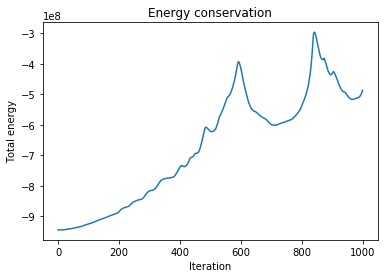

In [21]:
# Plot the total energy of every iteration of the simulation to verify that energy conservation isn't blatantly being violated.
plt.title('Energy conservation')
plt.plot(E_all)
plt.ylabel('Total energy')
plt.xlabel('Iteration')
plt.show()

The following density plots and animation detail the evolution of the periodic system over time.

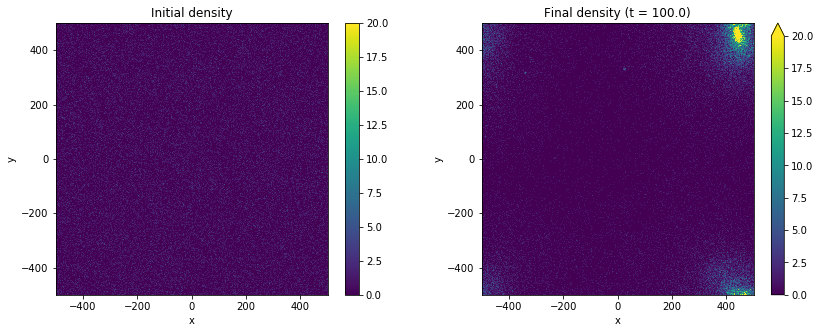

In [22]:
# Plot the initial and final mass density distributions.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_title('Initial density')
im1 = ax1.imshow(density_all[0], origin='lower', extent=extent, vmax=20)
f.colorbar(im1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_title('Final density (t = {:.1f})'.format(dt*nstep))
im2 = ax2.imshow(density_all[-1], origin='lower', extent=extent, vmax=20)
f.colorbar(im2, ax=ax2, extend='max')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.show()

In [23]:
# Animate it!
t = np.arange(0,nstep*dt,dt)
timestamp = ['t = {:.2f}'.format(ti) for ti in t]

fig = plt.figure(figsize=(9,6))
ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))
im = ax.imshow(density_all[0], origin='lower', extent=extent, vmax=20)
f.colorbar(im, extend='max')
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes, c='w')
plt.close()

def animate(i):
    im.set_data(density_all[i])
    time_text.set_text(timestamp[i])
    return im, time_text

anim = animation.FuncAnimation(fig, animate, frames=nstep, interval=50)
anim.save('periodic_nbody.mp4', dpi=213.33)

### Non-periodic (circular) BCs

For non-periodic boundary conditions, we need to add a removal mechanism for particles that have escaped the simulation box as well as improve the Green's function and FFT convolution scheme. To eliminate the periodic potentials that result automatically from the FFT convolution, I will pad the arrays with zeros. However, padding the arrays with zeros introduces significant edge effects, so we need to expand the Green's function to twice the size of the simulation box, so that the edges of the Green's function never affect the potential calculation.

In [24]:
def destroy_particles(x, y, vx, vy, extent):
    '''
    Only returns the positions and velocities of particles that are within the bounds of the simulation box.
    The information for particles outside the box is lost/removed.
    '''
    xmin, xmax, ymin, ymax = extent
    idx_keep = [(x >= xmin)&(x < xmax)&(y >= ymin)&(y < ymax)]
    x = x[idx_keep]
    y = y[idx_keep]
    vx = vx[idx_keep]
    vy = vy[idx_keep]
    return x, y, vx, vy

def get_circular_Green(npix, extent, soft=0.01):
    '''
    Wrapper for the get_Green function defined earlier. The returned array is twice as large as the density array 
    because this allows the non-periodic potential to be smooth throughout the entire simulation box (i.e. if the particle 
    is located in a corner, the potential obtained using this Green's function will be smooth/continuous all the way to the 
    opposite corner).
    '''
    xmin, xmax, ymin, ymax = extent
    # Determine the size of the box.
    dx = xmax - xmin
    dy = ymax - ymin
    # Need to get the array of gridpoints for an area that is 2x larger than the simulation box.
    # For an even number of bins:
    if npix % 2 == 0:
        xedges = np.linspace(xmin - dx/2, xmax + dx/2, 2*npix+1)
        yedges = np.linspace(ymin - dy/2, ymax + dy/2, 2*npix+1)
        x_gridpt = (xedges[1:] + xedges[:-1])/2
        y_gridpt = (yedges[1:] + yedges[:-1])/2
    # For an odd number bins:
    if npix % 2 == 1:
        assert 1 == 0, 'Circular Green\'s function not yet implemented for an odd number of bins.'
    # Build the Green's function with the expanded gridpoints. Essentially, wraps around the earlier Green's function builder,
    # but shift by -h/2 instead of +h/2 (because it works this way for some reason).
    X, Y = np.meshgrid(x_gridpt, y_gridpt)
    shift = 0
    if len(x_gridpt) % 2 == 0: # only applies when there are even number of grid cells per side
        h = x_gridpt[1]-x_gridpt[0]
        shift = -h/2 
    R = np.sqrt((X-shift)**2 + (Y-shift)**2)
    R[R < soft] = soft
    return 1/R


def leapfrog_circular(x, y, vx_half, vy_half, npix, extent, green):
    '''
    Similar to leapfrog_periodic, but removes particles that escape the simulation box. Also, it takes the larger sized Green's
    function developed above for non-periodic (circular) boundary conditions, and it uses 
    '''
    x += vx_half*dt
    y += vy_half*dt
    x, y, vx_half, vy_half = destroy_particles(x, y, vx_half, vy_half, extent) # apply boundary conditions
    # Get the forces acting on the particles in their updated positions.
    density, xedges, yedges, bin_idx = get_density_hist2d(x, y, npix, extent) # for large number of particles
    pot = fftconvolve(density, green, mode='same')
    grad_pot = np.gradient(pot)
    Fx = grad_pot[1]
    Fy = grad_pot[0]
    # Calculate the velocities for the next half-step.
    vx_half += Fx[bin_idx[:,1], bin_idx[:,0]]*dt
    vy_half += Fy[bin_idx[:,1], bin_idx[:,0]]*dt
    # Calculate the total energy (kinetic + potential).
    E = 0.5*np.sum(vx_half**2 + vy_half**2)-0.5*np.sum(pot)
    return x, y, vx_half, vy_half, density, E

In [25]:
def nbody_circular(n_particles, x, y, vx, vy, npix, extent, nstep, dt, soft):
    '''
    Similar function to nbody, but the scalar potential field is non-periodic (circular) and the particles are removed
    from the simulation if they escape the simulation box. Also, the non-periodic potential is calculated using scipy's
    fftconvolve function which pads the input arrays to convolve with the optimal number of zeros and re-centers the array
    on the first input array when the mode is set to 'same'.
    '''
    # Apply boundary conditions (i.e. if some particles are outside the simulation box, remove them).
    x, y, vx, vy = destroy_particles(x, y, vx, vy, extent)
    # Save the energy and density for every time step.
    E = np.zeros(nstep)
    density_all = np.zeros([nstep, npix, npix])
    
    # Set up the leapfrog algorithm:
    # Get the forces acting on the particles in their initial positions.
    density, xedges, yedges, bin_idx = get_density_hist2d(x, y, npix, extent)
    green = get_circular_Green(npix, extent, soft=soft)
    pot = fftconvolve(density, green, mode='same')
    grad_pot = np.gradient(pot)
    Fx = grad_pot[1]
    Fy = grad_pot[0]
    # Give the first set of velocities at t = dt/2.
    vx_half = vx + Fx[bin_idx[:,1], bin_idx[:,0]]*dt/2
    vy_half = vy + Fy[bin_idx[:,1], bin_idx[:,0]]*dt/2
    # Save the initial density and energy.
    density_all[0] = density
    E[0] = 0.5*np.sum(vx_half**2 + vy_half**2) - 0.5*np.sum(pot)
    
    # Leapfrog for the remaining time steps.
    for i in range(1,nstep):
        x, y, vx_half, vy_half, density_tmp, E_tmp = leapfrog_circular(x, y, vx_half, vy_half, npix, extent, green)
        density_all[i] = density_tmp
        E[i] = E_tmp
    return density_all, E

In [26]:
###############################################################
# SETTINGS (same as the periodic case)
xmin = -500; xmax = 500; ymin = -500; ymax = 500 # the edges of the simulation box (1000x1000)
npix = 1024 # the resolution of the simulation (works best for an odd number of pixels per side)
n = 500000 # the number of particles

dt = 0.1 # the time step
nstep = 500 # the number of timesteps to simulate
###############################################################
# Place the particle inside the simulation box.
x_particle = np.random.uniform(xmin, xmax, n)
y_particle = np.random.uniform(ymin, ymax, n)
# Start the particles at rest.
vx = np.zeros(n)
vy = np.zeros(n)
# Give the extent of the simulation box.
extent = [xmin, xmax, ymin, ymax]

density_all, E_all = nbody_circular(n, x_particle, y_particle, vx, vy, npix, extent, nstep, dt, soft=2.0)
# If this fails, the time step is too large. Try reducing it.

C:\Users\Trix\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\Trix\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
C:\Users\Trix\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will

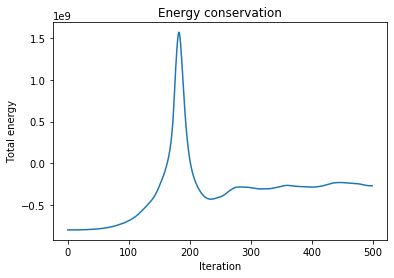

In [27]:
# Check energy conservation.
plt.title('Energy conservation')
plt.plot(E_all)
plt.ylabel('Total energy')
plt.xlabel('Iteration')
plt.show()

The total energy of the system is clearly not conserved in this case, as we can see it go from $-0.75\times 10^{9}$ to $+1.5\times 10^{9}$ before converging towards 0. Logically, this makes sense because the non-periodic system isn't closed: the mass is allowed to escape.

From the plots and animation below, we can see the differences between the periodic and non-periodic cases.

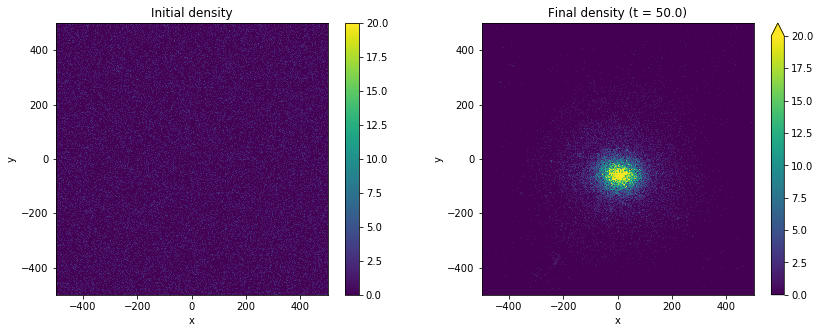

In [28]:
# Plot the initial and final mass density distributions.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_title('Initial density')
im1 = ax1.imshow(density_all[0], origin='lower', extent=extent, vmax=20)
f.colorbar(im1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_title('Final density (t = {:.1f})'.format(dt*nstep))
im2 = ax2.imshow(density_all[-1], origin='lower', extent=extent, vmax=20)
f.colorbar(im2, ax=ax2, extend='max')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.show()

In [29]:
# Animate it!
fig = plt.figure(figsize=(9,6))
ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))
im = ax.imshow(density_all[0], origin='lower', extent=extent, vmax=20)
f.colorbar(im, extend='max')
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes, c='w')
plt.close()

def animate(i):
    im.set_data(density_all[i])
    time_text.set_text(timestamp[i])
    return im, time_text

anim = animation.FuncAnimation(fig, animate, frames=nstep, interval=50)
anim.save('circular_nbody.mp4', dpi=213.33)

## Part 4: $k^{-3}$ mass fluctuations with periodic BCs

First, let's set up the initial parameters for the simulation as before.

In [30]:
###############################################################
# SETTINGS (same as the periodic case)
xmin = -500; xmax = 500; ymin = -500; ymax = 500 # the edges of the simulation box (1000x1000)
extent = [xmin, xmax, ymin, ymax]
npix = 1024 # the resolution of the simulation (works best for an odd number of pixels per side)
n = 500000 # the number of particles

dt = 0.1 # the time step
nstep = 1000 # the number of timesteps to simulate
###############################################################
# Place the particle inside the simulation box.
x_particle = np.random.uniform(xmin, xmax, n)
y_particle = np.random.uniform(ymin, ymax, n)
# Start the particles at rest.
vx = np.zeros(n)
vy = np.zeros(n)
# Give the extent of the simulation box.
extent = [xmin, xmax, ymin, ymax]

Now, we need to modify the initial density array that results from the uniform random particle positions at $t = 0$. The resulting initial density array should have mass fluctuations that are proportional to $k^{-3}$. To do this, we convert the initial density array to the Fourier domain and compute the third power of the density in Fourier space, which gives $k^3$. Then, we add random gaussian noise that is proportional to $k^{-3}$ to the density array in Fourier space, where the proportionality constant can be chosen to achieve different results. The final step is to transform back into the real domain to get the modified density array and from it, calculate the masses that should be given to each particle to produce the modified density array given that they are still in the same positions as before. 

In [31]:
# Start with the density array for the particles in the initial positions.
density, xedges, yedges, bin_idx = get_density_hist2d(x_particle, y_particle, npix, extent) # all masses are equal to 1 here

# Transform to Fourier space and add gaussian noise that is proportional to k^-3 to the Fourier transformed density array.
density_ft = np.fft.fft2(density)
k3 = np.abs(density_ft**3)
new_density_ft = density_ft + 1*np.random.randn(density_ft.shape[0], density_ft.shape[1])/k3 # chose the proportionality constant to be 1.

# Transform back to real space.
new_density = np.fft.fftshift(np.abs(np.fft.irfft2(new_density_ft)))
# Find the number of particles in each bin.
h = xedges[1] - xedges[0]
particles_in_bin = density[bin_idx[:,1], bin_idx[:,0]]*h
# Calculate the new mass for each particles.
new_m = (new_density[bin_idx[:,1], bin_idx[:,0]]/density[bin_idx[:,1], bin_idx[:,0]])/particles_in_bin

Now, most of the masses are quite small (less than 1) and a very small fraction of the particles are more massive than before. This is closer to the stellar mass distribution of a real universe!

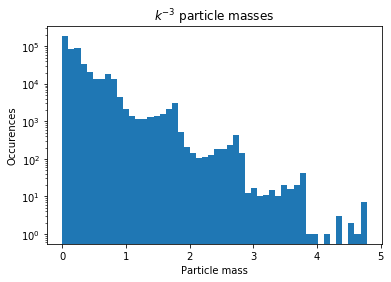

In [32]:
plt.title(r'$k^{-3}$ particle masses')
plt.hist(new_m, 50, log=True)
plt.xlabel('Particle mass')
plt.ylabel('Occurences')
plt.show()

Go through the N-body simulation with periodic boundary conditions and the particle masses we set above.

In [33]:
density_all, E_all = nbody_periodic(n, x_particle, y_particle, vx, vy, npix, extent, nstep, dt, soft=2.0, m=new_m)

We can see that energy is not conserved as well as it was before...

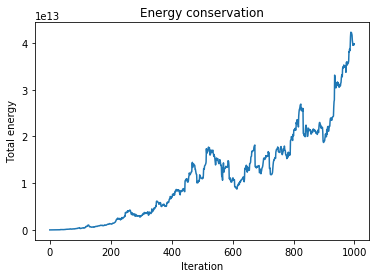

In [34]:
# Check energy conservation.
plt.title('Energy conservation')
plt.plot(E_all)
plt.ylabel('Total energy')
plt.xlabel('Iteration')
plt.show()

This new universe takes longer to collapse because its overall density is lower due to the large quantity of small masses and the comparatively few large masses. Mergers between different agglomerations of mass occur more gradually and less chaotically. Additionally, it's evolution appears to pass through some transient state where loose "strings" of particles connect the larger blobs together, before settling on some final state that is less compact than the earlier periodic simulation.

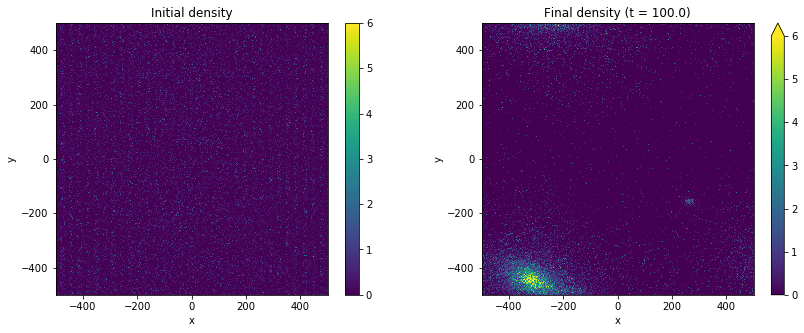

In [35]:
# Plot the initial and final mass density distributions.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_title('Initial density')
im1 = ax1.imshow(density_all[0], origin='lower', extent=extent, vmax=6)
f.colorbar(im1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_title('Final density (t = {:.1f})'.format(dt*nstep))
im2 = ax2.imshow(density_all[-1], origin='lower', extent=extent, vmax=6)
f.colorbar(im2, ax=ax2, extend='max')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.show()

In [36]:
# Animate it!
t = np.arange(0,nstep*dt,dt)
timestamp = ['t = {:.1f}'.format(ti) for ti in t]

fig = plt.figure(figsize=(9,6))
ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))
im = ax.imshow(density_all[0], origin='lower', extent=extent, vmax=6)
f.colorbar(im, extend='max')
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes, c='w')
plt.close()

def animate(i):
    im.set_data(density_all[i])
    time_text.set_text(timestamp[i])
    return im, time_text

anim = animation.FuncAnimation(fig, animate, frames=nstep, interval=50)
anim.save('k3_nbody.mp4', dpi=213.33)